# Get ready

First, download, import, prep packages and such. 

Then, check the file location and import the .csv files. Remove any with empty text fields. 

Save a data frame with all the texts and another with only those texts that mention the keywords of interest. 

In [1]:
%%capture

# installing necessary pdf conversion packages via pip
# the '%%capture' at the top of this cell suppresses the output (which is normally quite long and annoying looking). 
# You can remove or comment it out if you prefer to see the output. 
!pip install nltk


In [5]:
%%capture

import os                         # os is a module for navigating your machine (e.g., file directories).
import nltk                       # nltk stands for natural language tool kit and is useful for text-mining. 
from nltk import word_tokenize    # and some of its key functions

nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import wordnet                    # Finally, things we need for lemmatising!
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()
nltk.download('averaged_perceptron_tagger')        # Like a POS-tagger...
nltk.download('wordnet')
nltk.download('webtext')
from nltk.corpus import webtext

import pandas as pd
pd.set_option('display.max_colwidth', 200)
import numpy as np
import statistics
import datetime
date = datetime.date.today()

import codecs
import csv                        # csv is for importing and working with csv files

from collections import Counter

import statistics
import re                         # things we need for RegEx corrections
import matplotlib.pyplot as plt
import string 

import math 

English_punctuation = "-!\"#$%&()'*-–+,./:;<=>?@[\]^_`{|}~''“”"      # Things for removing punctuation, stopwords and empty strings
table_punctuation = str.maketrans('','', English_punctuation)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mzyssjkc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to

In [ ]:
print(os.listdir("..\\results")  )

files = []
def import_results(input):
    for f in os.listdir(input):
        f = pd.read_csv(input + '\\'+ f,encoding='latin1')
        files.append(f)
    output = pd.concat(files)
    return output

In [14]:
all_results = import_results("..\\results")
len(all_results)

69178

69178

In [15]:
all_counts_by_year = all_results['Year'].value_counts()
all_counts_by_year = pd.DataFrame(all_counts_by_year)
all_counts_by_year = all_counts_by_year.rename(columns={"Year": "Counts"})
all_counts_by_year = all_counts_by_year.rename_axis('Year').reset_index()
all_counts_by_year = all_counts_by_year.sort_values(by=['Year'])

In [16]:
no_null_texts = all_results[~all_results['Text'].isnull()]
len(no_null_texts)

67550

67550

In [22]:
no_null_counts_by_year = no_null_texts['Year'].value_counts()
no_null_counts_by_year = pd.DataFrame(no_null_counts_by_year)
no_null_counts_by_year = no_null_counts_by_year.rename(columns={"Year": "All"})
no_null_counts_by_year = no_null_counts_by_year.rename_axis('Year').reset_index()
no_null_counts = no_null_counts_by_year.sort_values(by=['Year'])

In [23]:
matched_texts = no_null_texts[no_null_texts['Text'].str.contains('autis|Autis|ASD|Asperger|asperger')]
len(matched_texts)

1948

1948

In [24]:
matched_counts_by_year = matched_texts['Year'].value_counts()
matched_counts_by_year = pd.DataFrame(matched_counts_by_year)
matched_counts_by_year = matched_counts_by_year.rename(columns={"Year": "Matches"})
matched_counts_by_year = matched_counts_by_year.rename_axis('Year').reset_index()
matched_counts_by_year = matched_counts_by_year.sort_values(by=['Year'])

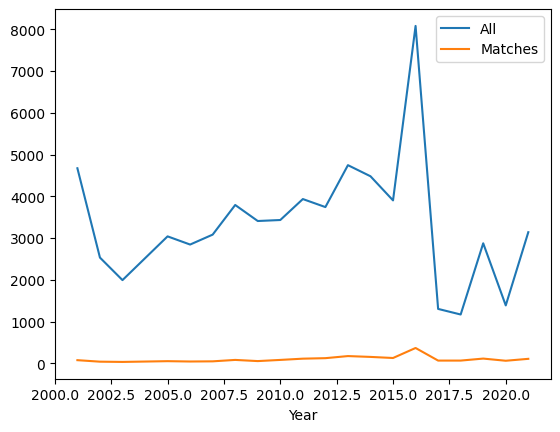

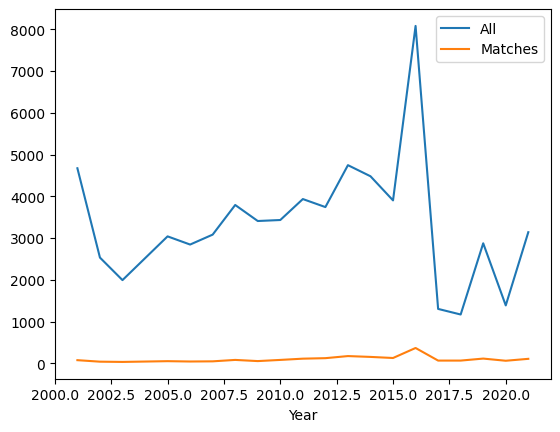

In [25]:
counts_year = no_null_counts_by_year.merge(matched_counts_by_year, on='Year', how='left')
counts_year = counts_year.sort_values(by='Year')
counts_year = counts_year.set_index('Year')
counts_year.plot()
plt.show()

In [34]:
print(counts_year)

       All  Matches
Year               
2001  4672       74
2002  2532       38
2003  1992       32
2005  3040       50
2006  2844       42
2007  3082       46
2008  3792       80
2009  3408       52
2010  3432       80
2011  3934      110
2012  3742      122
2013  4746      172
2014  4480      152
2015  3902      126
2016  8082      366
2017  1302       64
2018  1168       64
2019  2874      112
2020  1386       60
2021  3140      106
       All  Matches
Year               
2001  4672       74
2002  2532       38
2003  1992       32
2005  3040       50
2006  2844       42
2007  3082       46
2008  3792       80
2009  3408       52
2010  3432       80
2011  3934      110
2012  3742      122
2013  4746      172
2014  4480      152
2015  3902      126
2016  8082      366
2017  1302       64
2018  1168       64
2019  2874      112
2020  1386       60
2021  3140      106


# Count word frequencies 
## Bag of words

Proceed through the 'bag of words' steps for the data frames with all texts and then again for the data frame with only the texts that mention the keywords of interest. This approach finds word frequencies for all years together. 

In [26]:
def bag_of_words_analysis(input, how_many):
    holding_string = ""
    for text in input['Text']:
        holding_string += text
    holding_string = word_tokenize(holding_string)
    holding_string = [word.lower() for word in holding_string]
    holding_string = [w.translate(table_punctuation) for w in holding_string]
    holding_string = (list(filter(lambda x: x, holding_string)))
    holding_string = [token for token in holding_string if not token.isdigit()]
    holding_string = [token for token in holding_string if token not in stop_words]
    holding_string = [porter.stem(token) for token in holding_string]
    list_for_count = []
    for token in holding_string:
        list_for_count.append(token)
    counts = Counter(list_for_count)
    return counts.most_common(how_many)

In [27]:
bag_of_words_analysis(no_null_texts, 13)

[('gene', 135282),
 ('patient', 115584),
 ('mutat', 108042),
 ('none', 86454),
 ('genet', 82134),
 ('studi', 64300),
 ('use', 57006),
 ('result', 51040),
 ('case', 50622),
 ('associ', 49384),
 ('analysi', 48022),
 ('diseas', 47234),
 ('famili', 46170)]

[('gene', 135282),
 ('patient', 115584),
 ('mutat', 108042),
 ('none', 86454),
 ('genet', 82134),
 ('studi', 64300),
 ('use', 57006),
 ('result', 51040),
 ('case', 50622),
 ('associ', 49384),
 ('analysi', 48022),
 ('diseas', 47234),
 ('famili', 46170)]

In [28]:
bag_of_words_analysis(matched_texts, 13)

[('none', 4550),
 ('patient', 4272),
 ('gene', 3940),
 ('genet', 2397),
 ('delet', 2318),
 ('disord', 2285),
 ('autism', 2252),
 ('syndrom', 2156),
 ('mutat', 2008),
 ('asd', 1990),
 ('case', 1886),
 ('clinic', 1838),
 ('de', 1818)]

[('none', 4550),
 ('patient', 4272),
 ('gene', 3940),
 ('genet', 2397),
 ('delet', 2318),
 ('disord', 2285),
 ('autism', 2252),
 ('syndrom', 2156),
 ('mutat', 2008),
 ('asd', 1990),
 ('case', 1886),
 ('clinic', 1838),
 ('de', 1818)]

### Word Frequency by year

In [29]:

def track_word_over_time(input, target_word):
    years = input['Year'].drop_duplicates()
    target_counts = []
    for year in years:
        year_bag = ""
        for text in input['Text'][input['Year']==year]:
            year_bag += text
        year_bag = word_tokenize(year_bag)
        year_bag = [word.lower() for word in year_bag]
        year_bag = [w.translate(table_punctuation) for w in year_bag]
        year_bag = (list(filter(lambda x: x, year_bag)))
        year_bag = [token for token in year_bag if not token.isdigit()]
        year_bag = [token for token in year_bag if token not in stop_words]
        year_bag = [porter.stem(token) for token in year_bag]
        list_for_count = []
        for token in year_bag:
            list_for_count.append(token)
        counts = Counter(list_for_count)
        target_counts.append(counts[target_word])
        
    target_word_by_year = pd.DataFrame(list(zip(years, target_counts)), columns = ['Year', str(target_word)])
    return target_word_by_year


In [30]:
gene = track_word_over_time(no_null_texts, 'gene')
autism = track_word_over_time(no_null_texts, 'autism')
mutat = track_word_over_time(no_null_texts, 'mutat')

target_words = gene.merge(autism, on='Year').merge(mutat, on='Year')

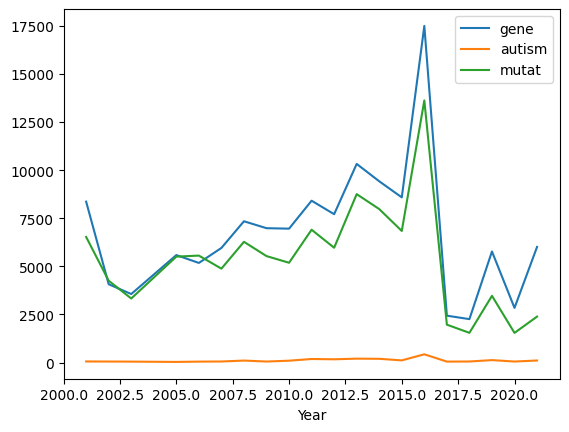

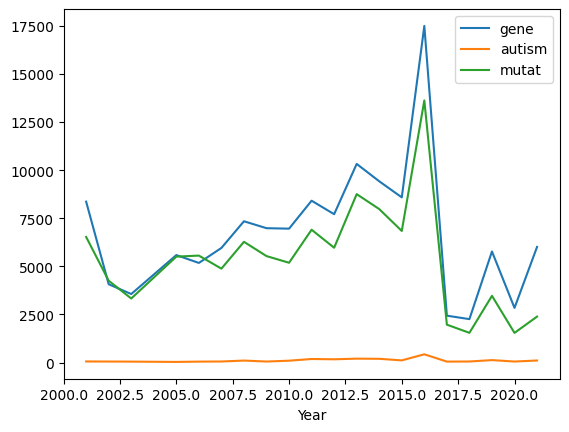

In [31]:
target_words = target_words.set_index('Year')
target_words.plot.line()
plt.show()

In [33]:
diseas = track_word_over_time(no_null_texts, 'diseas')
disord = track_word_over_time(no_null_texts, 'disord')


In [ ]:
condition = track_word_over_time(no_null_texts, 'condit')
syndrom = track_word_over_time(no_null_texts, 'syndrom')

target_words_2 = diseas.merge(disord, on='Year').merge(syndrom, on='Year')

In [37]:
target_words_2

,Year,diseas,disord,condition
0,2001,2600,1416,0
1,2002,1532,918,0
2,2003,1138,652,0
3,2005,1969,1110,0
4,2006,2096,1184,0
5,2007,1858,1052,0
6,2008,2424,1336,0
7,2009,2222,1252,0
8,2010,2292,1278,0
9,2011,2794,1700,0


,Year,diseas,disord,condition
0,2001,2600,1416,0
1,2002,1532,918,0
2,2003,1138,652,0
3,2005,1969,1110,0
4,2006,2096,1184,0
5,2007,1858,1052,0
6,2008,2424,1336,0
7,2009,2222,1252,0
8,2010,2292,1278,0
9,2011,2794,1700,0


In [36]:
target_words_2 = target_words.set_index('Year')
target_words_2.plot.line()
plt.show()

KeyError: "None of ['Year'] are in the columns"

KeyError: "None of ['Year'] are in the columns"

### Word frequency by session code
